In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.font_manager import FontProperties
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from transformers import (
    pipeline, 
    AutoTokenizer,
    AutoModelForSequenceClassification
)
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%matplotlib inline


In [4]:
# report style 設定
plt.style.use('ggplot')
fontproperties = FontProperties(fname='font_ch.ttf', size=14)
font = 'font_ch.ttf'
stopword_file_zhTW = 'stopwords_zhTW.txt'


In [5]:
# Initialize drivers
ws_driver = CkipWordSegmenter(level=3, device=0)

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

# 加載 RoBERTa-base chinese fine-tuned model (for text classification) - https://huggingface.co/uer/roberta-base-finetuned-jd-full-chinese
tokenizer = AutoTokenizer.from_pretrained('uer/roberta-base-finetuned-jd-full-chinese')
model = AutoModelForSequenceClassification.from_pretrained('uer/roberta-base-finetuned-jd-full-chinese')
# test the pretrained model
sentiment_classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)
res = sentiment_classifier('要买就买贵的不想比来比去，做工、效果非常好，不用出门在家减脂瑜伽都可以！')
print(res[0]['label'][-1])


5


In [6]:
print('Loading Traditional Chinese stopwords...')
stopwords_zhTW = list()
with open(stopword_file_zhTW, 'r', encoding='utf-8') as f:
    for l in tqdm(f.readlines()):
        if not len(l.strip()):
            continue
        stopwords_zhTW.append(l.strip())

stopwords_zhTW += ['想','請問','收到','剛剛']


Loading Traditional Chinese stopwords...


100%|██████████| 2870/2870 [00:00<00:00, 602756.62it/s]


In [109]:
data = pd.read_csv('chatbot_data_seg.csv', error_bad_lines=False)
data = data[data['re'].notnull()].reset_index(drop=True)

# data['類目'].value_counts().reset_index().sort_values('類目', ascending=False)
# data.head(5)
data[data['Question'].str.contains('信用卡')]
# data[data['標註']!='0']
# data.info()
# data.isnull().sum()


b'Skipping line 6000: expected 19 fields, saw 35\nSkipping line 9001: expected 19 fields, saw 23\nSkipping line 15013: expected 19 fields, saw 32\nSkipping line 18014: expected 19 fields, saw 32\n'
b'Skipping line 32963: expected 19 fields, saw 24\nSkipping line 38962: expected 19 fields, saw 35\nSkipping line 41963: expected 19 fields, saw 23\nSkipping line 47975: expected 19 fields, saw 32\nSkipping line 50976: expected 19 fields, saw 32\n'


,Question,Intent,FAQ_Answer1,FAQ_Answer2,FAQ_Answer3,阿發會出現什麼,標註,new_label,類目,cat1,cat2,cat3,cat4,cat_new,main_id,labelencoder,id,re,seg
4,想問信用卡可不可以使用,fallback,申辦信用卡是否一定能核發,信用卡扣繳保費,學生申請信用卡額度調高,申辦信用卡是否一定能核發,0,申辦信用卡是否一定能核發,信用卡|業務|卡片申請,信用卡,業務,卡片申請,無,信用卡-業務,21193,26,21193-@--@-信用卡|業務|卡片申請,想問信用卡可不可以使用,"['想問', '信用卡']"
9,信用卡電話更改,fallback,修改信用卡通訊資料,修改資料相關問題,國泰世華客服專線,修改信用卡通訊資料,0,修改信用卡通訊資料,信用卡|業務,信用卡,業務,無,無,信用卡-業務,21192,22,21192-@--@-信用卡|業務,信用卡電話更改,"['信用卡', '電話', '更改']"
15,信用卡核准,fallback,卡片寄出時間,申請信用卡天數說明,信用貸款申請進度,卡片寄出時間,0,卡片寄出時間,信用卡|業務,信用卡,業務,無,無,信用卡-業務,2209,22,2209-@--@-信用卡|業務,信用卡核准,"['信用卡', '核准']"
17,信用卡 健康檢查,fallback,紅利點數兌換方式,無法刷卡原因,身體健康,紅利點數兌換方式,0,紅利點數兌換方式,信用卡|業務,信用卡,業務,無,無,信用卡-業務,17725,22,17725-@--@-信用卡|業務,信用卡健康檢查,"['信用卡', '健康', '檢查']"
19,請問刷國泰世華的信用卡繳保險可以分期嗎,installment.apply,信用卡繳保費分期說明,信用卡扣繳保費,分期產品介紹,"installment.apply,信用卡繳保費分期說明",0,信用卡繳保費分期說明,信用卡|業務|分期|活動,信用卡,業務,分期,活動,信用卡-業務,19760,25,19760-@--@-信用卡|業務|分期|活動,請問刷國泰世華的信用卡繳保險可以分期嗎,"['問刷國', '泰世華', '信用卡', '保險']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66303,差不到有效信用卡,fallback,信用卡到期續卡方式,信用卡卡號或效期,國外預借現金,信用卡到期續卡方式,0,信用卡到期續卡方式,信用卡|業務,信用卡,業務,無,無,信用卡-業務,34329,22,34329-@--@-信用卡|業務,差不到有效信用卡,"['差不到', '信用卡']"
66309,信用卡無法感應,fallback,毀損補發信用卡,無法刷卡原因,感應式交易功能,毀損補發信用卡,毀損補發信用卡,毀損補發信用卡,信用卡|卡片,信用卡,卡片,無,無,信用卡-卡片,34540,6,34540-@--@-信用卡|卡片,信用卡無法感應,"['信用卡', '無法', '感應']"
66337,我的信用卡卡號,creditLimit.queryAmount,信用卡卡號或效期,ATM轉帳繳信用卡帳單方式,申請停用信用卡,信用卡卡號或效期,信用卡卡號或效期,信用卡卡號或效期,信用卡|業務,信用卡,業務,無,無,信用卡-業務,35346,22,35346-@--@-信用卡|業務,我的信用卡卡號,"['信用卡', '卡號']"
66341,信用卡中獎發票如何領取,fallback,電子發票信用卡載具功能,信用卡電子發票中獎通知,電子發票存入信用卡方式,電子發票信用卡載具功能,電子發票信用卡載具功能,電子發票信用卡載具功能,信用卡|業務,信用卡,業務,無,無,信用卡-業務,35507,22,35507-@--@-信用卡|業務,信用卡中獎發票如何領取,"['信用卡', '中獎', '發票', '領取']"


In [8]:
sent_list = data.re.values
# word_list = ws_driver(sent_list, use_delim=True)

In [23]:
cat_list = list()
for i in range(len(data)):
    try:
        cat_list += data['類目'][i].split('|')
    except:
        cat_list += ['']
        print(data['類目'][i])

cat_list[:5]


Inference: 100%|██████████| 260/260 [02:02<00:00,  2.12it/s]


['信用卡', '卡片', 'KOKO(PLAY/NBA)', '銀行', '理財投資']

In [9]:
def getSentimentScore(sent):
    _ = sentiment_classifier(sent)
    label = _[0]['label']
    score = _[0]['score']

sentiment_list = list()
for sent in tqdm(sent_list):
    try:
        sentiment_list.append(sentiment_classifier(sent))
    except:
        print(sent)
        sentiment_list.append((0.0, 0.0))

sentiment_list[:10]


100%|██████████| 66350/66350 [26:20<00:00, 41.97it/s]


[[{'label': 'star 4', 'score': 0.3821466565132141}],
 [{'label': 'star 4', 'score': 0.42447739839553833}],
 [{'label': 'star 1', 'score': 0.43302515149116516}],
 [{'label': 'star 1', 'score': 0.24196097254753113}],
 [{'label': 'star 2', 'score': 0.2655748724937439}],
 [{'label': 'star 1', 'score': 0.6410739421844482}],
 [{'label': 'star 2', 'score': 0.3717615604400635}],
 [{'label': 'star 1', 'score': 0.37669193744659424}],
 [{'label': 'star 4', 'score': 0.4177226126194}],
 [{'label': 'star 1', 'score': 0.2921123504638672}]]

In [85]:
df_kw_sent = pd.DataFrame({
    'keyword': data['類目'].values.tolist(), 
    'sentiment': [item[0]['label'][-1] for item in sentiment_list],
    'confidence': [round(float(item[0]['score']), 3) for item in sentiment_list],
})
df_kw_sent.head()
df_kw_sent['sentiment'] = df_kw_sent['sentiment'].astype(int)
df_kw_sent = df_kw_sent.drop('keyword', axis=1).join(df_kw_sent['keyword']
                                                    .str
                                                    .split('|', expand=True)
                                                    .stack()
                                                    .reset_index(drop=True, level=1)
                                                    .rename('keyword'))
df_kw_sent = df_kw_sent.drop('keyword', axis=1).join(df_kw_sent['keyword']
                                                    .str
                                                    .split(',', expand=True)
                                                    .stack()
                                                    .reset_index(drop=True, level=1)
                                                    .rename('keyword'))
df_kw_sent = df_kw_sent.groupby(['keyword']).agg({'keyword': 'count', 'sentiment': 'mean', 'confidence': 'mean'}).rename(columns={'keyword': 'count'})
df_kw_sent['x'] = np.random.random(df_kw_sent.shape[0])
df_kw_sent['y'] = np.random.random(df_kw_sent.shape[0])
for col in df_kw_sent.columns[1:]:
    df_kw_sent[col] = df_kw_sent[col].apply(lambda x: (x - np.min(df_kw_sent[col])) / (np.max(df_kw_sent[col]) - np.min(df_kw_sent[col])))
df_kw_sent['count'] = np.log(df_kw_sent['count']) * 1000
df_kw_sent = df_kw_sent.reset_index()
df_kw_sent.sort_values('sentiment')



,keyword,sentiment,confidence
0,信用卡|卡片|KOKO(PLAY/NBA),4,0.382
1,銀行|理財投資|基金,4,0.424
2,信用卡|業務|帳單繳費相關,1,0.433
3,銀行|業務,1,0.242
4,信用卡|業務|卡片申請,2,0.266


,keyword,count,sentiment,confidence,x,y
17,保險,1386.294361,0.000000,0.461244,0.678665,0.681970
2,閒聊,1791.759469,0.000000,0.050078,0.970261,0.693379
40,春節,1386.294361,0.250000,0.000000,0.078815,0.911518
37,收單,4510.859507,0.269231,0.280048,0.483046,0.681179
51,行動銀行,6419.994928,0.274430,0.265663,0.952665,0.246609
...,...,...,...,...,...,...
1,優惠,693.147181,0.750000,0.590392,0.361309,0.442238
0,信用卡,693.147181,0.750000,0.590392,0.971496,0.358201
54,貴賓權益,3465.735903,0.781250,0.689230,0.135534,0.950342
30,基金投資,2995.732274,0.800000,0.360034,0.383014,0.661397


In [93]:
fig = px.scatter(df_kw_sent, x='x', y='y', size='count', color='sentiment', 
                 opacity=df_kw_sent['confidence'].values, text='keyword', size_max=19, height=1000, width=1000)
fig.show()


In [92]:
fig = px.scatter(df_kw_sent, x='confidence', y='sentiment', size='count', color='sentiment', 
                 opacity=df_kw_sent['confidence'].values, 
                 text='keyword', height=1000, width=1000)
fig.show()


In [105]:
# data[data['類目'].str.contains('保險|閒聊')].head(5)
data[data['類目'].str.contains('新年|外匯|人臉')].head(30)

# 能否有時間流？ 知道用戶是否因為回覆文不對題而離開
# 是否知道用戶有無點擊阿發出現的資訊卡
# 計算回覆和提問的相似度


,Question,Intent,FAQ_Answer1,FAQ_Answer2,FAQ_Answer3,阿發會出現什麼,標註,new_label,類目,cat1,cat2,cat3,cat4,cat_new,main_id,labelencoder,id,re,seg
3449,拒絕人臉辨識,installment.apply,人臉辨識介紹,人臉辨識功能,人臉辨識申請方式,"installment.apply,人臉辨識介紹",0,人臉辨識介紹,銀行|業務|人臉辨識,銀行,業務,人臉辨識,無,銀行-業務,21427,64,21427-@--@-銀行|業務|人臉辨識,拒絕人臉辨識,"['拒絕', '臉辨識']"
11682,登入方式設定,fallback,設定及使用人臉登入行動銀行方式,設定網路安全認證密碼方式,約定帳戶的設定方法,設定及使用人臉登入行動銀行方式,0,設定及使用人臉登入行動銀行方式,銀行|業務|人臉辨識,銀行,業務,人臉辨識,無,銀行-業務,21636,64,21636-@--@-銀行|業務|人臉辨識,登入方式設定,"['登入', '方式', '設定']"
23566,我沒做人臉辨識阿,bank.turnToReal,人臉辨識介紹,人臉辨識功能,人臉辨識申請方式,"bank.turnToReal,人臉辨識介紹",0,人臉辨識介紹,銀行|業務|人臉辨識,銀行,業務,人臉辨識,無,銀行-業務,27793,64,27793-@--@-銀行|業務|人臉辨識,我沒做人臉辨識阿,['臉辨識']
27002,人臉辨識,installment.apply,人臉辨識介紹,人臉辨識功能,人臉辨識申請方式,"installment.apply,人臉辨識介紹",0,人臉辨識介紹,銀行|業務|人臉辨識,銀行,業務,人臉辨識,無,銀行-業務,28082,64,28082-@--@-銀行|業務|人臉辨識,人臉辨識,"['人臉', '辨識']"
30405,人像辨識,installment.apply,人臉辨識介紹,人臉辨識申請方式,人臉辨識功能,"installment.apply,人臉辨識介紹",0,人臉辨識介紹,銀行|業務|人臉辨識,銀行,業務,人臉辨識,無,銀行-業務,15114,64,15114-@--@-銀行|業務|人臉辨識,人像辨識,"['人像', '辨識']"
32549,KOKO調整轉帳金額限制,fallback,KOKO使用人臉轉帳手機版本,KOKO轉帳介紹,KOKO數位帳戶介紹,KOKO使用人臉轉帳手機版本,0,KOKO使用人臉轉帳手機版本,銀行|業務|人臉辨識,銀行,業務,人臉辨識,無,銀行-業務,25667,64,25667-@--@-銀行|業務|人臉辨識,KOKO調整轉帳金額限制,"['KOKO', '調整', '轉帳', '金額']"
36403,拒絕人臉辨識,installment.apply,人臉辨識介紹,人臉辨識功能,人臉辨識申請方式,"installment.apply,人臉辨識介紹",0,人臉辨識介紹,銀行|業務|人臉辨識,銀行,業務,人臉辨識,無,銀行-業務,21427,64,21427-@--@-銀行|業務|人臉辨識,拒絕人臉辨識,"['拒絕', '臉辨識']"
44636,登入方式設定,fallback,設定及使用人臉登入行動銀行方式,設定網路安全認證密碼方式,約定帳戶的設定方法,設定及使用人臉登入行動銀行方式,0,設定及使用人臉登入行動銀行方式,銀行|業務|人臉辨識,銀行,業務,人臉辨識,無,銀行-業務,21636,64,21636-@--@-銀行|業務|人臉辨識,登入方式設定,"['登入', '方式', '設定']"
56520,我沒做人臉辨識阿,bank.turnToReal,人臉辨識介紹,人臉辨識功能,人臉辨識申請方式,"bank.turnToReal,人臉辨識介紹",0,人臉辨識介紹,銀行|業務|人臉辨識,銀行,業務,人臉辨識,無,銀行-業務,27793,64,27793-@--@-銀行|業務|人臉辨識,我沒做人臉辨識阿,['臉辨識']
59956,人臉辨識,installment.apply,人臉辨識介紹,人臉辨識功能,人臉辨識申請方式,"installment.apply,人臉辨識介紹",0,人臉辨識介紹,銀行|業務|人臉辨識,銀行,業務,人臉辨識,無,銀行-業務,28082,64,28082-@--@-銀行|業務|人臉辨識,人臉辨識,"['人臉', '辨識']"


In [98]:
ws_nostopwords = list()
for wl in tqdm(word_list):
    ws_nostopwords.append([w for w in wl if w not in stopwords_zhTW])
word_list = ws_nostopwords.copy()
# ws_nostopwords = list()


NameError: name 'word_list' is not defined

In [28]:
from collections import Counter

def makeCounter(word_list):
    counter = dict()
    for wl in word_list:
        for k, v in dict(Counter(wl)).items():
            if k not in counter.keys():
                counter.update({k: v})
            else:
                counter.update({k: counter[k] + v})

    return counter

# counter = makeCounter(word_list=word_list)
cat_counter = Counter(cat_list)
cat_counter


Counter({'信用卡': 41463,
         '卡片': 7316,
         'KOKO(PLAY/NBA)': 499,
         '銀行': 18794,
         '理財投資': 330,
         '基金': 500,
         '業務': 31801,
         '帳單繳費相關': 11722,
         '卡片申請': 2047,
         '年費規則': 298,
         '網路銀行': 2361,
         '活動': 3482,
         '優惠': 2975,
         '分期': 1523,
         '繳費繳稅(代扣繳)': 933,
         '外匯存款': 2884,
         'ATM金融卡': 2094,
         '專屬優惠': 1242,
         '台幣業務': 4152,
         '信託業務': 544,
         '閒聊': 3696,
         'KOKO': 619,
         '費用類': 2393,
         '電子票證': 618,
         '一卡通': 108,
         '票據業務': 461,
         'VIP': 213,
         'I刷': 718,
         '其他': 2017,
         '回饋方式': 734,
         '優惠權益': 107,
         '悠遊卡': 381,
         '行動支付': 276,
         '收單': 91,
         '表單下載': 230,
         '申辦方法': 637,
         '國泰優惠': 233,
         'MY ATM': 110,
         'COSTCO卡': 804,
         'ICASH': 129,
         '貸款': 900,
         '雙幣卡': 143,
         '首刷禮': 51,
         '貴賓室': 680,
         '聯徵、強停': 17

In [29]:
ws_tfidf_vector = vectorizer.fit_transform([' '.join(w) for w in word_list])
print(vectorizer.get_feature_names()[:10])
print(vectorizer.get_feature_names()[-10:])
print(ws_tfidf_vector.shape)


['0000', '004', '0050', '006', '007', '008', '0081131', '009', '0102', '0104']
['鼓勵', '龍勝', '龍卡', '龍腾卡', '龍騰', '龍騰卡', '龍騰卡號', '龍騰卡邦卡', '龍鰧', '龍鰧卡']
(66350, 4989)


In [30]:
ws_tfidf_vector = ws_tfidf_vector.toarray()
avg_tfidf_by_word = list()
for i in tqdm(range(ws_tfidf_vector.shape[1])):
    avg_tfidf_by_word.append(ws_tfidf_vector[:, i].sum())


100%|██████████| 4989/4989 [00:06<00:00, 793.08it/s]


In [31]:
word_tfidf_dict = dict(zip(vectorizer.get_feature_names(), avg_tfidf_by_word))


<Figure size 864x648 with 0 Axes>

(-0.5, 399.5, 299.5, -0.5)

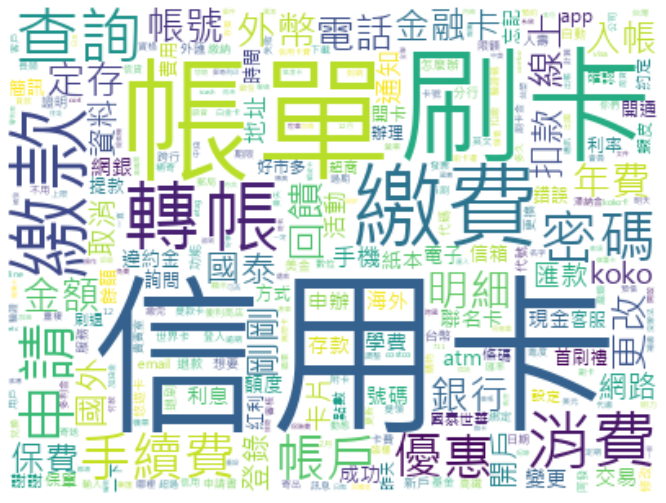

In [13]:
wc = WordCloud(background_color='white', max_words=ws_tfidf_vector.shape[1], font_path=font, width=400, height=300)
wc.generate_from_frequencies(word_tfidf_dict)
plt.figure(figsize=(12, 9))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.savefig('afa_question_wordcloud_tfidf.jpg')
plt.show()


<Figure size 1008x576 with 0 Axes>

(-0.5, 499.5, 299.5, -0.5)

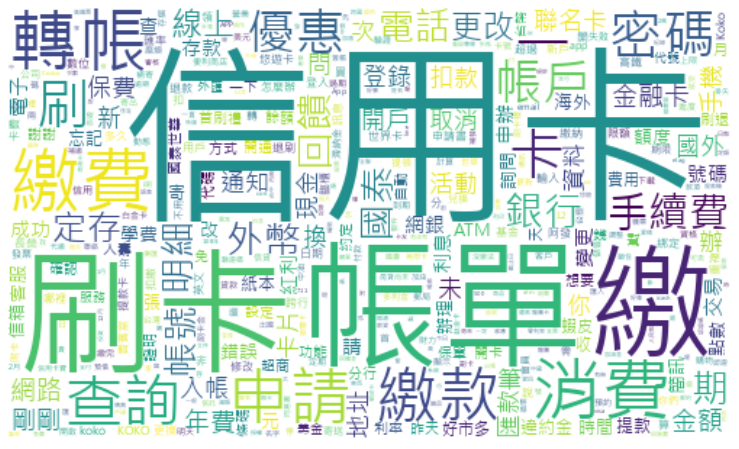

In [14]:
wc = WordCloud(background_color='white', max_words=len(counter.keys()), font_path=font, width=500, height=300)
wc.generate_from_frequencies(counter)
plt.figure(figsize=(14, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


<Figure size 1008x576 with 0 Axes>

(-0.5, 499.5, 299.5, -0.5)

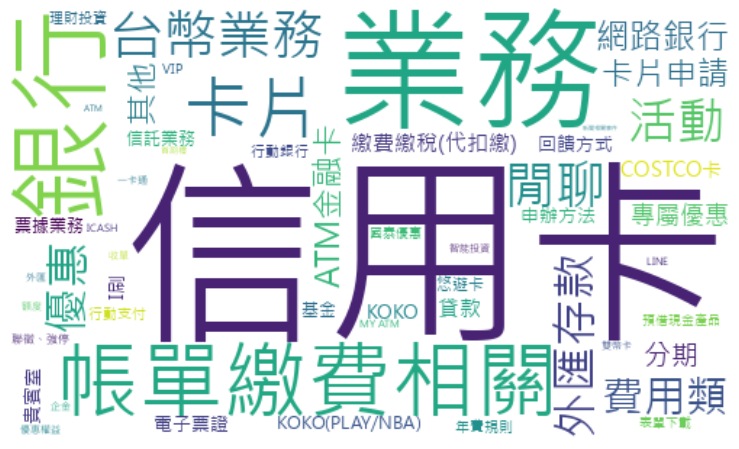

In [15]:
wc = WordCloud(background_color='white', max_words=len(cat_counter.keys()), font_path=font, width=500, height=300)
wc.generate_from_frequencies(cat_counter)
plt.figure(figsize=(14, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


In [32]:
df_tfidf = pd.DataFrame(word_tfidf_dict.items(), columns=['keyword', 'importance']).sort_values('importance')

In [33]:
import plotly.express as px

fig = px.bar(df_tfidf.tail(30), 
             x='importance', y='keyword', orientation='h', height=1000, width=500)
fig.show()
